In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz

%matplotlib inline


# backpropagation is applying the chain rule locally backwards through the chain
# topilogical means all nodes are laid out from left to right in one line

# initialize o.grad as 1.0 because you multiply it in
# o._backward() which will make it 0 if you don't initialize 

# there is a bug that we must fix
# this happens when you use the same node twice
# multivariable calculus chain rule says that gradients should 'accumulate'
# grad should be 2 but since we initiate a 1.0 we get 1.0 * 1.0
# neural nets are mathamatical expressions that take input as data dealing with loss function and propagating forwards + backwards all with biases and weights

In [35]:
def f(x):
    return 3*x**2 - 4*x + 5

# here we are defining f(x)

In [36]:
f(3.0)
# here we enter a value for f

20.0

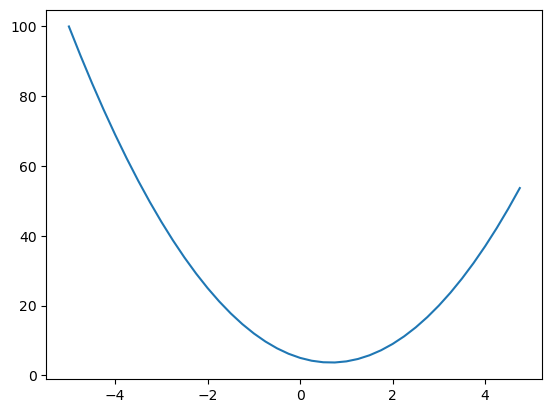

In [37]:
xs = np.arange(-5, 5, 0.25)
# x values
ys = f(xs)
# y values
plt.plot(xs, ys)
# plot the xs and ys

In [38]:
h = 0.00001
x = 2/3
(f(x + h) - f(x))/h

3.0000002482211127e-05

In [39]:
#now more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

#d is a value created by three scalar objects
print(d)

4.0


In [40]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2- d1)/h)
#the slope is the rate at which d increases as we move down the line

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [41]:
class Value:
    
    #_children will be a tuple and later a class
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    #we are making a string that presents the data value
    def __repr__(self):
        return f"Value(data={self.data})"
    
    #we must define how to add since python can't add objects
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward

        return out
    
    def backward(self):
        # this will build a topilogical graph
        # topilogical means all nodes are laid out from left to right in one line
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited: # if not visited
                visited.add(v) # mark as visited
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [42]:
# this is a forward pass
a = Value(2.0)
b = Value(4.)
a - b

Value(data=-2.0)

In [43]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid) # here we created edges

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [44]:
# dL / de = -2.0

# e = a * b
# de / da? b

# dL / da = (dL / de) * (de /da)

In [45]:
# L = d * f

# dL/dd =? f

# (f(x+h)-f(x))/h

# ((d+h)*f - d*f)/h
# (d*f + h*f -d*f) / h
# (h*f)/h
# f

In [46]:
# dd / dc = 1.0
# dd / de = 1.0
# d = c + e

# (f(x +h) - f(x)) / h

# ((c+h + e) - (c + e))/h
# (c + h + e - c - el)/h

# h/h

# 1.0

# look up the CHAIN RULE from calculus and refresh

# WANT:
# dL / dc = (dL/dd * dd/dc)

# KNOW:
# dL / dd
# dd / dc

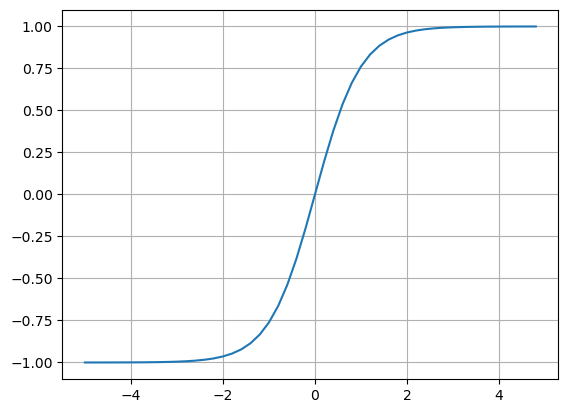

In [47]:
# this is tanh
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [48]:
# inputs x1, x2
# this is a two dimensional neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
# weights are the synamptic strength of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# this is the bias
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#output
o = n.tanh(); o.label = 'o'

o.backward()

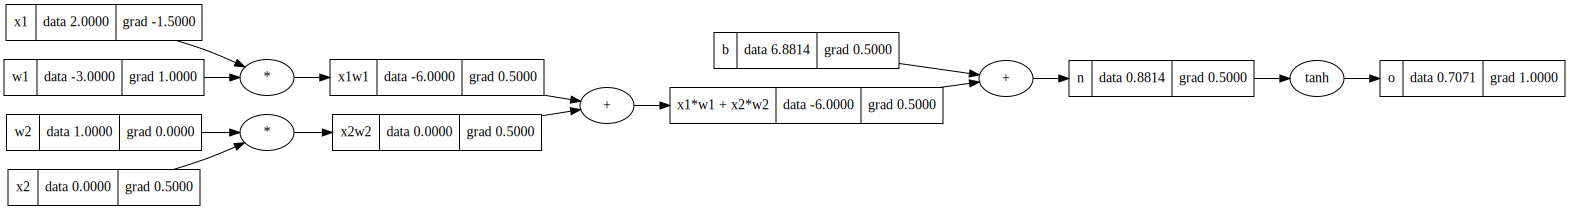

In [49]:
draw_dot(o)

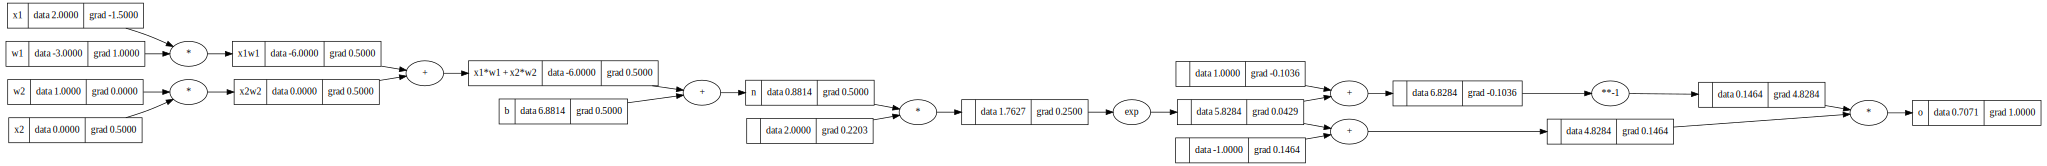

In [50]:
# inputs x1, x2
# this is a two dimensional neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
# weights are the synamptic strength of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# this is the bias
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#output
# we are breaking up tanh
e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

o.backward()

draw_dot(o)

In [51]:
import torch

In [52]:
# this helps create single scalar tensors
# we can use pytorch to create micrograd only if we deal with
    # single element tensors first

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# we will "strip" out the tensor to get one item
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [53]:

import random

# r = random.randint(1,10)

class Neuron:
  
  def __init__(self, nin): # creates a weight and bias for the neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    # w * x is a dot product
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout): # list of neurons and how many
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs # get the last layer's neuron out

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
        # this line is the same as below
        # params = []
        # for neurons in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP:
  
  def __init__(self, nin, nouts): # number of inputs, and take a list of layers
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [117]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.9739353508960829)

In [118]:
n.parameters()
#41 parameters in the NLP

[Value(data=0.21685011836557178),
 Value(data=0.495903772154753),
 Value(data=0.3003260227102702),
 Value(data=0.45976213540860256),
 Value(data=-0.23417543492913673),
 Value(data=0.9469076439321864),
 Value(data=-0.19963606736331285),
 Value(data=0.9087825312978275),
 Value(data=0.2709658983729968),
 Value(data=-0.35353076192393695),
 Value(data=-0.963873541643073),
 Value(data=-0.17241429751326764),
 Value(data=-0.46976923862477027),
 Value(data=0.1813022111119169),
 Value(data=0.6665301450378276),
 Value(data=-0.6212631590176758),
 Value(data=0.04671868487101416),
 Value(data=0.7141164177270356),
 Value(data=0.9298032926994739),
 Value(data=-0.6177145849853083),
 Value(data=-0.4697738115412087),
 Value(data=-0.7213868822286442),
 Value(data=-0.9199102684511813),
 Value(data=-0.421229734015075),
 Value(data=-0.7487796258863539),
 Value(data=0.9319165578048552),
 Value(data=-0.94338157701057),
 Value(data=-0.7855253410551681),
 Value(data=-0.4666956984981483),
 Value(data=0.9721290574

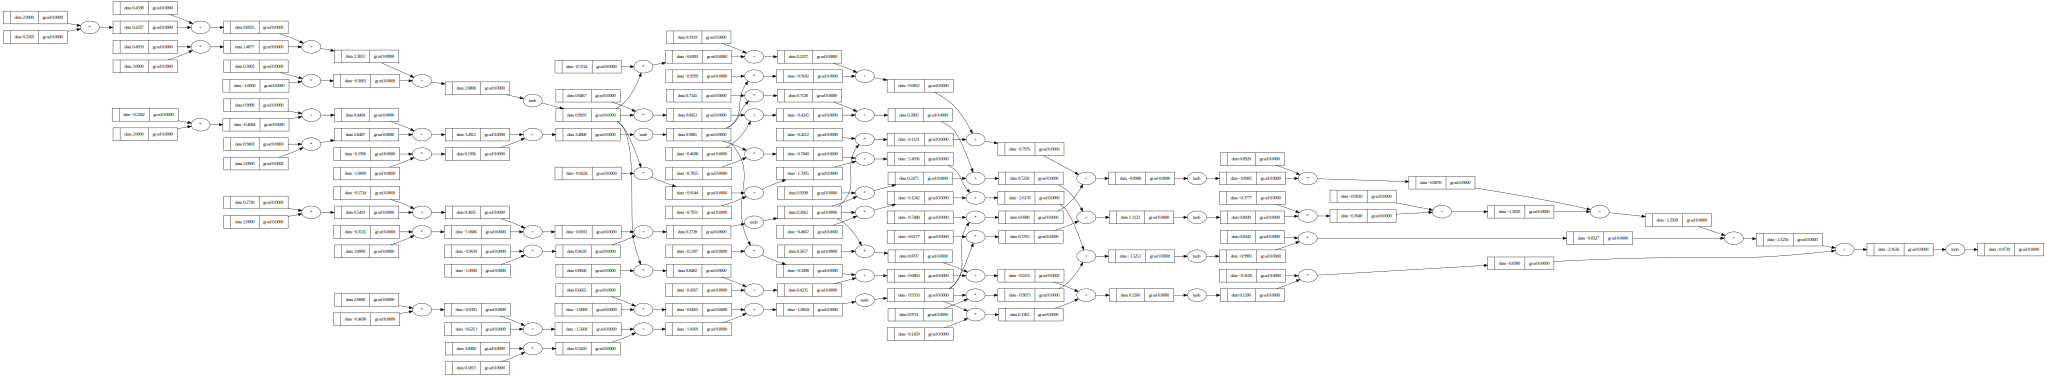

In [119]:
draw_dot(n(x))

In [120]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [189]:
# loss measures how well the neural net is performing
# minimize loss

# if you prediction is exactly the target you're going to get 0.0
# the parameter of range() is how many steps you want
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad
        
    print(k, loss.data)

0 0.0004040244508409921
1 0.00040353760307105786
2 0.00040305186297274326
3 0.0004025672268298309
4 0.0004020836909425529
5 0.00040160125162748254
6 0.00040111990521744486
7 0.000400639648061485
8 0.00040016047652467637
9 0.0003996823869881415
10 0.00039920537584888063
11 0.0003987294395197385
12 0.00039825457442928226
13 0.0003977807770217446
14 0.0003973080437569256
15 0.00039683637111009623
16 0.00039636575557194396
17 0.0003958961936484488
18 0.000395427681860847
19 0.00039496021674551647


In [ ]:
# gradient descent is made of these last three cells
# forward pass, backward pass, update
# the neural net improves its predictions each time

In [191]:
ypred

[Value(data=0.9898481653345724),
 Value(data=-0.9869220697343909),
 Value(data=-0.9946055939008286),
 Value(data=0.9904204074994587)]